# Credit Card Fraud Detection using Extreme Gradient Boosting
## Ekaba Bisong

## 1. Introduction
Credit card fraud detection is the science and art of detecting unusual activity in credit transactions. Fraud occurs when the credit card information of an individual is stolen and used to make unauthorized purchases and or withdrawals from the original holders account.

### The Data Science Approach to Fraud Detection
Learning from historical data forms the bedrock of the data science approach. By making use of statistical methods, a classification model is developed to map a function that learns to identify when a fraudulent transaction has occurred. The approach is typically divided into two perspectives, the supervised and unsupervised norms.

In the supervised norm, the function is trained using previous labelled data of fraudulent and normal transactions, so the function is taught to understand intrinsically what makes a transaction fraudulent. The trained function is now used to determine if a new transaction is fraudulent or not. While in the unsupervised norm, techniques such as anomaly detection is used to identify fraudulent transactions as outliers in a dimensional space. Future transactions which fall outside a particular region is further investigated as a fraudulent transaction.

Several studies have investigated different Machine Learning approaches to develop a computational model to identify the incidence of fraud. Some of the techniques from literature include artificial neural networks, bayesian belief networks[$^1$](https://www.researchgate.net/profile/Karl_Tuyls/publication/248809471_Credit_Card_Fraud_Detection_Applying_Bayesian_and_Neural_networks/links/0deec52519708c5f7a000000.pdf), and hidden markov models[$^2$](http://ieeexplore.ieee.org/document/4358713/).

### Challenges to Credit Fraud Detection
A major challenge to credit fraud detection research is the availability of real world data due to privacy and legal concerns.

## 2. The Dataset
The dataset has been collected and analysed during a research collaboration of Worldline and the [Machine Learning Group of ULB (Université Libre de Bruxelles)](http://mlg.ulb.ac.be) on big data mining and fraud detection. The dataset is made available on [Kaggle](https://www.kaggle.com/dalpozz/creditcardfraud).

### Dataset Description
**Description from [Kaggle](https://www.kaggle.com/dalpozz/creditcardfraud)**
> The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset present transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

> It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

## 3. Data Preparation Techniques

In [1]:
# import packages
print(__doc__)
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc

Automatically created module for IPython interactive environment


In [2]:
# load the data
dataframe = pd.read_csv("creditcard.csv")

In [3]:
# get column names
colNames = dataframe.columns.values
colNames

array(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',
       'Amount', 'Class'], dtype=object)

In [4]:
# get dataframe dimensions
print "Dimension of dataset:", dataframe.shape

Dimension of dataset: (284807, 31)


In [5]:
# get attribute summaries
print(dataframe.describe())

                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  3.919560e-15  5.688174e-16 -8.769071e-15  2.782312e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean  -1.552563e-15  2.010663e-15 -1.694249e-15 -1.927028e-16 -3.137024e-15   
std    1.380247e+00  1.332271e+00  1.23709

In [6]:
# get class distribution
print "Normal transaction:", dataframe['Class'][dataframe['Class'] == 0].count() #class = 0
print "Fraudulent transaction:", dataframe['Class'][dataframe['Class'] == 1].count() #class = 1

Normal transaction: 284315
Fraudulent transaction: 492


In [7]:
# separate classes into different datasets
class0 = dataframe.query('Class == 0')
class1 = dataframe.query('Class == 1')

# randomize the datasets
class0 = class0.sample(frac=1)
class1 = class1.sample(frac=1)

#### Undersampling to deal with class imbalance
The examples of the majority class, in this case the normal transactions drastically outnumber the incidences of fraud in our dataset. One of the strategies employed in the data science community is to delete instances from the over-represented class to improve the learning function. Here, we selected 6000 instances of the normal class from the original 284315 records.

In [8]:
# undersample majority class due to class imbalance before training - train
class0train = class0.iloc[0:6000]
class1train = class1

# combine subset of different classes into one balaced dataframe
train = class0train.append(class1train, ignore_index=True).values

In [9]:
# split data into X and y
X = train[:,0:30].astype(float)
Y = train[:,30]

## 4. The Learning Algorithm: XGBoost
Extreme Gradient Boosting is also known as XGBoost. This model is preferred due to its execution speed and learning performance. It has been the algorithm of choice for various winners of Kaggle and KDD Mining Cup competitions. It is implemented in the scikit learn python package. Orginally written in C++ by [Tianqi Chen](http://homes.cs.washington.edu/~tqchen/)

In [10]:
# XGBoost CV model
model = XGBClassifier()
kfold = StratifiedKFold(n_splits=10, random_state=7)

# use area under the precision-recall curve to show classification accuracy
scoring = 'roc_auc'
results = cross_val_score(model, X, Y, cv=kfold, scoring = scoring)
print("AUC: %.3f (%.3f)") % (results.mean(), results.std())

AUC: 0.979 (0.011)


## 5. Plot the Result

In [11]:
# change size of Matplotlib plot
fig_size = plt.rcParams["figure.figsize"] # Get current size

old_fig_params = fig_size
# new figure parameters
fig_size[0] = 12
fig_size[1] = 9
   
plt.rcParams["figure.figsize"] = fig_size # set new size

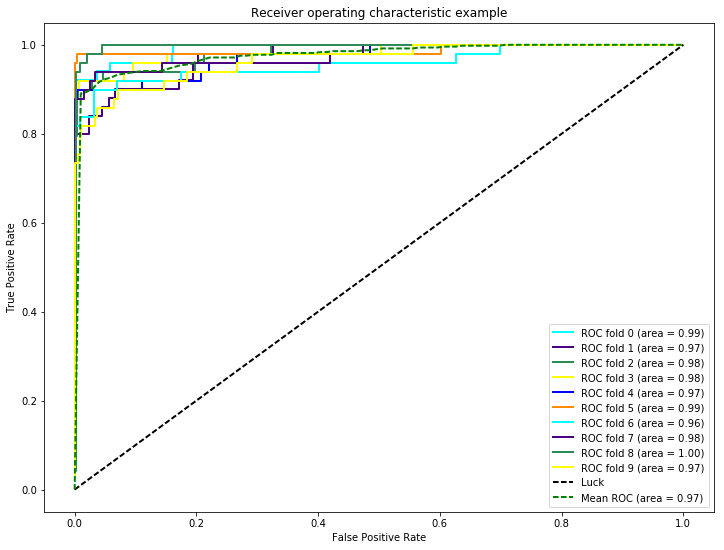

In [12]:
# plot roc-curve
# code adapted from http://scikit-learn.org
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
lw = 2

i = 0
for (train, test), color in zip(kfold.split(X, Y), colors):
    probas_ = model.fit(X[train], Y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(Y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= kfold.get_n_splits(X, Y)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## 6. Remarks
From the above results our algorithm achieved auc-roc (i.e. area under the precision-recall curve) score of 0.979. The auc-roc curve in insensitive to class imbalanace and hence is the preferred evaluation metric for estimating the performance of our learning function.

### Further Remarks
Several other techniques that can be explored/ benchmarked:
- Visualization to understand the transaction trends over time, more ideas can be gotten to understand more about fraudulent transactions
- Research deep learning techniques to this problem such as Reccurent Neural Networks using the time component for sequence-to-sequence learning
- Consider other learning options such as anomaly detection or change detection